# Mount St. Helens Countour Dataset

In [1]:
import math
import numpy as np
import torch
import gpytorch
import tqdm
import random
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import sys
import sys
import scipy.io
import torch
import numpy as np 
sys.path.append("../directionalvi")
#sys.path.append("../../data")
sys.path.append("../directionalvi/utils")
from directional_vi import train_gp
from metrics import MSE
from metrics import MAE


in Directional Grad Variational Strategy.py


In [2]:
#load data
mat = scipy.io.loadmat('MtSH.mat')
x = torch.tensor(np.float64(mat['mth_points'])).float()
y = torch.tensor(np.float64(mat['mth_verts'])).float()
y = y - torch.mean(y)
dy = torch.tensor(np.float64(mat['mth_grads'])).float()
data = torch.cat((y, dy), dim = 1).float()
full_data = torch.cat((x, data), dim=1).float() #location concatenated with y and dy values


# Filter and Round Dataset (If Applicable)

In [3]:
temp_full_data = np.array(full_data)
def fun(x, val = 250):
    if x[0]>250 or x[1]>250:       
        return False 
    else:
        return True
filtered = filter(fun, temp_full_data)
#for item in filtered:
#    print(item)
arr = [item for item in filtered]
len_arr = len(arr)
len_arr = len_arr - len_arr%100
arr = arr[:len_arr]
#full_data_truncated = torch.tensor(arr)
print(len(arr))

900


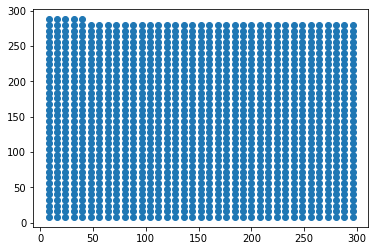

In [33]:
xs1 = [item[0] for item in arr]
xs2 = [item[1] for item in arr]
plt.scatter(xs1, xs2)

In [34]:
#recover x and data from filtered concatenated values
x = torch.tensor([item[0:2] for item in arr])
data = torch.tensor([item[2:] for item in arr])
data[:, 0] = data[:, 0] - torch.mean(data[:, 0]) #normalize
print(max(data[:, 0]))
print(min(data[:, 0]))

tensor(412.5541)
tensor(-225.6771)


In [35]:
# data parameters
n  = data.shape[0] 
dim = 2
n_test = n//10

# training params
num_inducing = 400
num_directions = dim
minibatch_size = n_test #how does minibatch size impact convergence rate
num_epochs = 4000

#print
print("n is: ", n)
print("n_test is: ", n_test)
print("num_inducing is:", num_inducing)
print("num_directions is: ", num_directions)

# generate training data
dataset = TensorDataset(x, data)

n is:  1300
n_test is:  130
num_inducing is: 400
num_directions is:  2


# Plotting

In [7]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_test, n-n_test], generator=torch.Generator().manual_seed(42))

In [8]:
train_dataset
train_loader  = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
dim = len(train_dataset[0][0])
n_samples = len(train_dataset)

In [9]:
n_samples

90

model,likelihood = train_gp(train_dataset,
                      num_inducing=num_inducing,
                      num_directions=num_directions,
                      minibatch_size = minibatch_size,
                      minibatch_dim = num_directions,
                      num_epochs =num_epochs
                      )

In [22]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [23]:
torch.save(model.state_dict(), "helens_2_derivatives.model")

# Predict

In [24]:
x.size(-2)

900

In [25]:
test_loader  = DataLoader(test_dataset, batch_size=n_test, shuffle=True)
# predict in batches
kwargs = {}
derivative_directions = torch.eye(dim)[:num_directions]
derivative_directions = derivative_directions.repeat(n_test,1)
print(derivative_directions.shape)

torch.Size([180, 2])


In [26]:

kwargs['derivative_directions'] = derivative_directions
#means   = model(test_x, **kwargs).mean.cpu()
means = torch.tensor([0.])
test_y = torch.zeros(1,dim+1)
test_x = torch.zeros(1,dim)
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch,**kwargs)
        means = torch.cat([means, preds.mean.cpu()])
        test_y = torch.cat([test_y, y_batch])
        test_x = torch.cat([test_x, x_batch])

means = means[1:]
test_y = test_y[1:]
test_x = test_x[1:]


num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2
num_induc is:  400
num_data is:  90
num_derivative_directions is:  2
num_directions is:  2


In [27]:
# compute MSE
test_mse = MSE(test_y[:,0],means[::num_directions+1])
print(f"\nTesting MSE: {test_mse}")
print(f"\nTesting RMSE: {math.sqrt(test_mse)}")
test_mae = MAE(test_y[:,0],means[::num_directions+1])
print(f"\nTesting MAE: {test_mae}")


Testing MSE: 16052.6767578125

Testing RMSE: 126.69915847318205

Testing MAE: 101.95784759521484


In [28]:
# testing RMSE is 364 for 1000 epochs...
# 300 inducing, 900 datapoints, 10% test, 1500 epochs: MAE = 101, MSE = 126
#I suspect that 1500 epochs is not enough. Try 4000 if I have time...

# Plot Actual vs Prediction

NameError: name 'train_x' is not defined

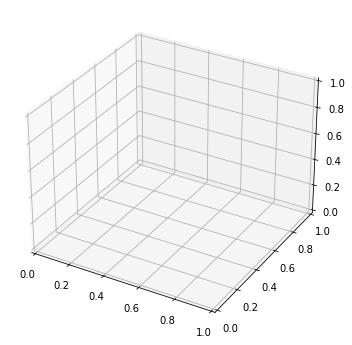

In [29]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_x[:,0],train_x[:,1],train_y[:,0], color='k')
ax.scatter(train_x[:,0],train_x[:,1],preds.detach().numpy()[::num_directions+1], color='b')
plt.title("f(x,y) variational fit; actual curve is black, variational is blue")
plt.show()

In [ ]:
x = torch.tensor([-1, -2, -3]).abs()

In [ ]:
x